In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Softmax Logistic Regression
Multinomial logistic regression (for more than 2 classes), but still, each sample can only belong to one class.

## The Model
<img src="pics/softmax.png">

## The Data
Make sure, it also works for separating the two Gaussian clouds:

In [176]:
N = 100 # Total number of samples
N_0 = int(N/2) # number of samples for class 0
N_1 = int(N/2) # number of samples for class 1
D = 2 # number of features/dimensions
K = 2 # number of output classes

In [193]:
mu_0 = [-2,-2]
variance = 1

mu_1 = [2,2]

m_cov = [[variance, 0],
         [0, variance]]
np.random.seed(41) # make the results reproducible
X = np.concatenate([np.random.multivariate_normal(mu_0, m_cov, N_0),
                    np.random.multivariate_normal(mu_1, m_cov, N_1)],
                   axis=0)
X.shape

(100, 2)

The target labels (indicator matrix):

In [194]:
T = np.zeros((N, K))
T[0:N_0,0]=1
T[N_0:,1]=1

In [195]:
pred_T = np.argmax(T, axis=1)

## Implementation of the Feed-Forward Pass
Initialise random weights and bias terms

In [206]:
np.random.seed(31)
Winitial = np.random.randn(D, K)
binitial = np.random.randn(K)

In [207]:
def forward(Xi, Wi, bi):
    Z = Xi.dot(Wi) + bi
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True) # (np.exp(Z).T / np.sum(np.exp(Z),axis=1)).T

In [208]:
Y = forward(X, Winitial, binitial)
Y.shape

(100, 2)

In [209]:
preds = np.argmax(Y, axis=1)

The classification rate:

In [210]:
np.sum(preds == pred_T)/len(T)*100

5.0

## The Loss Function
Multinomial logistic regression has a slightly different loss function than binary logistic regression because it uses the softmax rather than the sigmoid classifier. Consider for all training samples $\{x_n\}$ and classes k:
$t_{nk} = 1$ if the target for sample $n$ is of class $k$ and $=0$ otherwise. 

$$L_{\mathbf{W}, b} \stackrel{\text{def}}{=} \prod_{n=1}^N \prod_{k=1}^K y_{nk}^{\ \Large t_{nk}}$$

The Loss to be minimised is the negative log-likelihood, also called Categorical Cross Entropy Loss:

$$L_{CE}\stackrel{\text{def}}{=} - \sum_{n=1}^N \sum_{k=1}^K t_{nk} \log y_{nk} $$

If the more $y_{nk}$ is wrong, the larger the loss: Consider just 1 sample:

* Exactly right $\; \rightarrow \; L_{CE}=0$
* 50\% probability on correct target $\; \rightarrow \; L_{CE}=-1*\cdot\log(0.5)=0.693$
* 25\% probability on correct target $\; \rightarrow \; L_{CE}=-1*\cdot\log(0.25)=1.386$
* 0\% probability on correct target $\; \rightarrow \; L_{CE}=-1*\cdot\log(0)=\infty$


Or maximise the the log-likelihood:

$$J = \sum_{n=1}^N \sum_{k=1}^K t_{nk} \log y_{nk}$$


In [211]:
def cat_cross_entropy_loss(Ti, Yi):
    return -np.sum(Ti*np.log(Yi))

In [212]:
cat_cross_entropy_loss(T, Y)

192.19436480213216

## Optimisation
There is no closed-form solution for the optimal $W$ in softmax logistic regression $\rightarrow$ find the partial derivaties of $J$ with respect to the $W_{dk}$ and perform gradient descent.

$$z=W^Tx+b$$
$$y=softmax(z)$$
$$y_{nk} = \frac{e^{z_{nk}}}{\sum_{j=1}^K e^{z_{nj}}}$$

When deriving the partial derivative of $J$ with respect to $W_{dk}$ one has to consider the particular structure of the softmax function: Each $y_{nk}$ is a function of all $\{ a_{k'} \}_{1}^K$, each of which in turn is a function of $W_{dk}$. Hence the additional dummy variable $k'$ in:
$$\frac{\partial J}{\partial W_{dk}} = \sum_{n=1}^N \sum_{i=1}^K \frac{\partial J_{nk'}}{\partial y_{nk'}} \frac{\partial y_{nk'}}{\partial z_{nk}} \frac{\partial z_{nk}}{\partial W_{dk}}$$

$$\frac{\partial J_{nk'}}{\partial y_{nk'}} = \frac{t_{nk'}}{y_{nk'}}$$

$$\begin{aligned}
\frac{\partial y_{nk'}}{\partial z_{nk}} &= (-1)  e^{z_{nk'}} \left(\sum_j e^{z_{nj}}\right)^{-2}  e^{z_{nk}} \; \; \; \; \text{if} \; k'\neq k\\
&= (-1) \frac{e^{z_{nk'}}}{\sum_j e^{z_{nj}}} \frac{e^{z_{nk}}}{\sum_j e^{z_{nj}}}\\
&= -y_{nk'}y_{nk}\\
\end{aligned}$$

$$\begin{aligned}
\frac{\partial y_{nk'}}{\partial z_{nk}} &=  e^{z_{nk'}} \left(\sum_j e^{z_{nj}}\right)^{-1} -  e^{z_{nk'}} \left(\sum_j e^{z_{nj}}\right)^{-2} e^{z_{nk}} \; \; \; \; \text{if} \; k'= k\\
&= y_{nk'}(1-y_{nk}) \; \; \; \; \text{although} \; k=k'\\
\end{aligned}$$

with
$$\begin{aligned}
\delta_{kk'} &= 1 \; \; \; \; \text{if} \; k'= k \\
\delta_{kk'} &= 0 \; \; \; \; \text{if} \; k'\neq k
\end{aligned}$$
the expression simplifies to
$$\frac{\partial y_{nk'}}{\partial z_{nk}} = y_{nk'}(\delta_{kk'}-y_{nk})$$


$$z_{nk} = W_{:,k}^{T}x_n + b_k$$
$$\frac{\partial z_{nk}}{\partial W_{dk}} = x_{nd}$$

combine and simplify
$$\begin{aligned}
\frac{\partial J}{\partial W_{dk}} &= -\sum_{n=1}^N \sum_{i=1}^K \frac{t_{ni}}{y_{ni}} y_{ni}(\delta_{ki}-y_{nk}) x_{nd}\\
&= -\sum_{n=1}^N \sum_{i=1}^K t_{ni}(\delta_{ki}-y_{nk}) x_{nd}\\
&= -\sum_{n=1}^N x_{nd}\left( \sum_{i=1}^K t_{ni}\delta_{ki}- \sum_{i=1}^K t_{ni} y_{nk} \right)\\
&= -\sum_{n=1}^N \left(t_{nk} - y_{nk}\right) x_{nd}
\end{aligned}$$

In matrix form:
$$\nabla_{W} J=X^T(T-Y)$$

In code - gradient of the categorical cross-entropy loss (flipped sign):

In [213]:
def grad_w(Xi, Ti, Yi):
    return Xi.T.dot(Yi-Ti)

partial derivative with respect to bias term of class $k$:
$$\frac{\partial J}{\partial b_k} = \sum_{n=1}^N \sum_{i=1}^K \frac{\partial J_{ni}}{\partial y_{ni}} \frac{\partial y_{ni}}{\partial z_{nk}} \frac{\partial z_{nk}}{\partial b_k}$$

Realising that
$$\frac{\partial z_{nk}}{\partial b_k} = 1$$
and plugging in the intermediate results from above:

$$\frac{\partial J}{\partial b_k} = \sum_{n=1}^N \left(t_{nk}-y_{nk}\right)$$

In code (flipped sign):

In [225]:
def grad_b(Ti, Yi):
    return np.sum(Yi-Ti, axis=0)

In [221]:
iterations = 1000
lrate = 1e-4
losses = []

W = np.random.randn(D, K)
b = np.random.randn(K)

for i in range(iterations):
    Y = forward(X, W, b)
    loss = cat_cross_entropy_loss(T, Y)
    losses.append(loss)
    W = W - (lrate * grad_w(X, T, Y)) # minimise: follow the negative gradient
    b = b -(lrate * grad_b(T, Y))

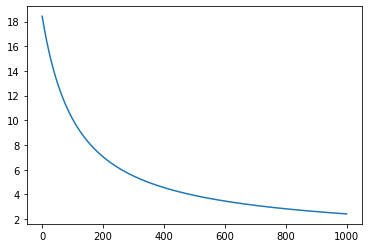

In [222]:
plt.plot(losses)

In [223]:
W

array([[-1.19296432, -0.07953072],
       [-1.14811897,  1.74749873]])

The classification rate:

In [224]:
np.sum(np.argmax(Y, axis=1) == pred_T)/len(T)*100

99.0